# Lab 3 — recommender systems

In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pyspark.mllib.recommendation as rec
import pickle

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.models import HoverTool

from matplotlib.colors import rgb2hex

from operator import itemgetter


%matplotlib inline
plt.style.use("ggplot")
output_notebook()

Loading BokehJS ...

## 3.4 Basic statistics

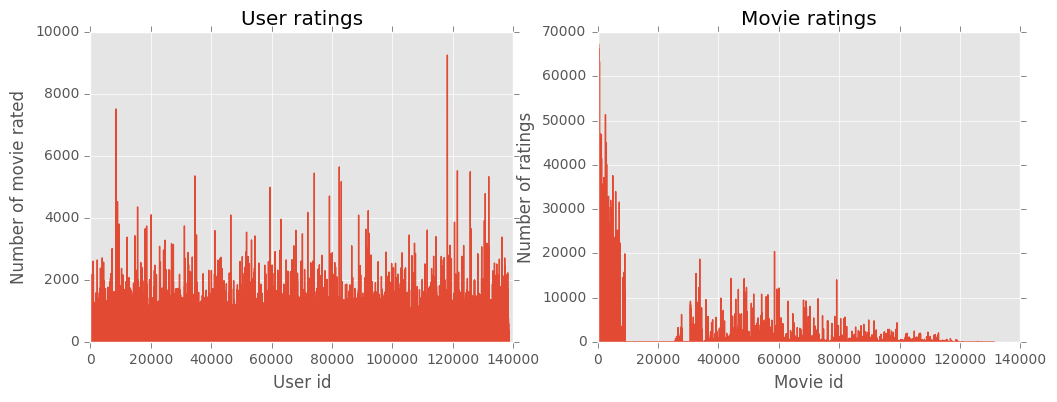

In [2]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

# We append our ratings to the ratings
myRatings = []
with open('my-ratings.txt','r') as file:
    for line in file:
        myRatings.append(json.loads(line))
myRatings = sc.parallelize(myRatings)
data = data.union(myRatings)

numRatings = data.count()
numUsers = data.map(lambda rating: rating['userId']).distinct().count()

# We get the number of rating per user id
usersRatingCount = data.map(lambda rating: (rating['userId'],1)).countByKey().items()

# We get the number of rating per movie id
moviesRatingCount = sorted(data.map(lambda rating: (rating['movieId'],1)).countByKey().items())

# Plotting
fig, axes = plt.subplots(1,2,figsize=(12.0,4.0))

ax = axes[0]
ax.plot(*zip(*usersRatingCount))
ax.set_xlabel('User id')
ax.set_ylabel('Number of movie rated')
ax.set_title('User ratings')

ax = axes[1]
ax.plot(*zip(*moviesRatingCount))
ax.set_xlabel('Movie id')
ax.set_ylabel('Number of ratings')
ax.set_title('Movie ratings')
plt.show();

## 3.5 Partioning the dataset

In [3]:
# If the last digit is 1 or 2, then we put it in the validation set
def isValidation(rating):
    if rating['timestamp']%10 in [1,2]:
        return True
    return False
def isTraining(rating):
    return not isValidation(rating)


# We separated the data into training and validation set
training, validation = (data.filter(f) for f in(isTraining,isValidation))

# We check that the repartition between training and validation is correct
trainingSize = training.count()
validationSize = validation.count()
print("Ratio of training is %.3f%% and validation is %.3f%%"%(trainingSize/numRatings*100,validationSize/numRatings*100))

Ratio of training is 80.001% and validation is 19.999%


## 3.6 Baseline model

In [4]:
mu = training.map(lambda rating: rating['rating']).mean()


# We first map the data to (userId,rating-mu),
# then we group by userId and map i to a list, we now have (userId,list(ratings-mu))
# then we compute the mean for each userId.
alpha = training.map(lambda rating: (rating['userId'],rating['rating']-mu))\
    .groupByKey().mapValues(list)\
    .map(lambda rating: (rating[0],np.mean(rating[1]))).collectAsMap()

# Same idea tha previously, but this time we do rating-alpha-mu
beta = training.map(lambda rating: (rating['movieId'],rating['rating']-alpha[rating['userId']]-mu))\
    .groupByKey().mapValues(list)\
    .map(lambda rating: (rating[0],np.mean(rating[1]))).collectAsMap()

# We compute the mean of alpha and beta to put it when we have
# no information about the user id or movie id
alphaMean = np.mean(list(alpha.values()))
betaMean = np.mean(list(beta.values()))

validationMap = validation.map(lambda rating: ((rating['userId'],rating['movieId']),rating['rating'])).collectAsMap()

# We create a dict of dict for our result, the first level is the userId
# the second level is the movieId
estimatedMap = defaultdict(lambda: {})
for userId, movieId in validationMap.keys():
    # We clip the estimated rating between 0.5 and 5, to be consistent with the original data
    estimatedMap[userId][movieId] = np.clip(mu+alpha.get(userId,alphaMean)+beta.get(movieId,betaMean),0.5,5.0)

## 3.7 Evaluation

In [5]:
# Error taking the estimate under the form of of a dict of dict
# with the first level for the userId and the second level movieId
def error(estimate):
    sumU = 0
    numUsers = 0
    for user in estimate.keys():
        sumM = 0
        numMovies = 0
        for movie, rating in estimate[user].items():
            sumM += (rating-validationMap[(user,movie)])**2
            numMovies += 1
        sumU += np.sqrt(1./numMovies*sumM)
        numUsers += 1
    return 1./numUsers*sumU

print("The error is of %.3f"%error(estimatedMap))

The error is of 0.867


## 3.8 Regularization

In [6]:
def computeError(rank=5,lambda_=0.0001):
    model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),5,lambda_=0.0001)
    prediction = model.predictAll(validation.map(lambda rating: (rating['userId'],rating['movieId'])))
    estimation = prediction.collect()
    estimate = defaultdict(lambda: {})
    for userId, movieId, rating in estimation:
        estimate[userId][movieId] =rating
    return error(estimate)

In [ ]:
model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),5,lambda_=0.0001)
prediction = model.predictAll(validation.map(lambda rating: (rating['userId'],rating['movieId'])))
estimation = prediction.collect()
estimatedMap2 = defaultdict(lambda: {})
for userId, movieId, rating in estimation:
    estimatedMap2[userId][movieId] =rating

In [20]:
for rank, lambda_ in [(5,0.0001),(13,0.0001),(25,0.0001),(5,10)]:
    print("Error with rank %d and lambda %f is %.3f"%(rank,lambda_,computeError(rank,lambda_)))

Error with rank 5 and lambda 0.000100 is 0.855
Error with rank 13 and lambda 0.000100 is 0.854
Error with rank 25 and lambda 0.000100 is 0.861
Error with rank 5 and lambda 10.000000 is 0.859


In [21]:
for rank, lambda_ in [(5,0.01),(13,0.01)]:
    print("Error with rank %d and lambda %f is %.3f"%(rank,lambda_,computeError(rank,lambda_)))

Error with rank 5 and lambda 0.010000 is 0.856
Error with rank 13 and lambda 0.010000 is 0.849


In [22]:
for rank, lambda_ in [(25,0.01)]:
    print("Error with rank %d and lambda %f is %.3f"%(rank,lambda_,computeError(rank,lambda_)))

Error with rank 25 and lambda 0.010000 is 0.853


In [8]:
results = []
for rank in [5,7,9,11,13,15,17,19,21,23,25]:
    results.append(computeError(rank))
    print("Error with rank %d and lambda %f is %.3f"%(rank,0.0001,results[-1]))

Error with rank 5 and lambda 0.000100 is 0.860
Error with rank 7 and lambda 0.000100 is 0.868
Error with rank 9 and lambda 0.000100 is 0.856
Error with rank 11 and lambda 0.000100 is 0.854
Error with rank 13 and lambda 0.000100 is 0.847
Error with rank 15 and lambda 0.000100 is 0.855
Error with rank 17 and lambda 0.000100 is 0.867


KeyboardInterrupt: 

In [26]:
for rank in [6,8,9]:
    print("Error with rank %d and lambda %f is %.3f"%(rank,lambda_,computeError(rank)))

KeyboardInterrupt: 

In [138]:
error(estimatedMap2) # rank =5, lambda = 0.5

1.0131218972771603

In [128]:
error(estimatedMap2) # rank =5, lambda = 0.0001

0.8524675667492102

In [140]:
error(estimatedMap2) # rank =5, lambda = 0.00001

0.88821879272498194

## 3.9 Recommendation

In [23]:
model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),5,lambda_=0.0001)

dataMovie = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie2name = dict(dataMovie.map(itemgetter("movieId", "title")).collect())

def recommendMovies(userId,number=10):
    movies = []
    for rating in model.recommendProducts(userId,number):
        movies.append(movie2name[rating[1]])
    return movies

print("Recommendations for user 123")
for movie in recommendMovies(123):
    print("-", movie)
print("\nRecommendations for us")
for movie in recommendMovies(138494):
    print("-",movie)

Recommendations for user 123


NameError: name 'model' is not defined

## 3.10 Visualisation

In [34]:
model2 = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),2,lambda_=0.0001)
features = model2.productFeatures().collectAsMap()

# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
data=dict(
            x=[],
            y=[],
            name=[],
            score=[],
            color=[],
        )

for movie in movies:
    coords = features[movie[0]]
    data['x'].append(coords[0])
    data['y'].append(coords[1])
    data['name'].append(movie[1])
    data['score'].append(movie[2])
    data['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
source = ColumnDataSource(data)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("RT score","@score"),
        ]
    )

p = figure(plot_width=600, plot_height=600, tools=[hover],
           title="Movies")

p.circle('x', 'y', size=20, source=source, color='color')

show(p)